<a href="https://colab.research.google.com/github/kwisetree/AIFFEL_quest_cr/blob/main/Exploration/SubQuestC27/SubQuestC27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#프로젝트 : ControlNet으로 조건을 준 이미지 생성하기

평가문항
1. 프롬프트와 하이퍼파라미터를 변경하여 윤곽선 검출 조건을 준 이미지를 생성하였는가?
2. 인체 자세 검출 전처리기를 이용하여 이미지를 생성하였는가?
3. 윤곽선 검출과 인체 자세 검출 전처리기를 사용하여 이미지를 생성하였는가?


## Step 1. 라이브러리 설치

In [ ]:
# 드라이브 마운팅

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Diffusers를 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

## Step 2. 윤곽선 검출

In [ ]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

In [ ]:
# Canny 알고리즘

import cv2
from PIL import Image
import numpy as np

# 이미지를 NumPy 배열로 변환합니다.
image = np.array(image)

# threshold를 지정합니다.
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다.
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다.

canny_image

In [ ]:
# 윤곽선 검출 전처리기를 사용한 모델 파이프라인 불러오기

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float32)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float32
)

## Step 3. 프롬프트 적용하여 이미지 생성

In [ ]:
import torch
from diffusers import UniPCMultistepScheduler

# CPU 사용 확인 메시지
print("CPU 사용 모드로 실행합니다.")

# 스케줄러 설정
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)

# 모델을 CPU로 명시적으로 설정
canny_pipe = canny_pipe.to("cpu")
print("모델이 CPU로 설정되었습니다.")

# 동일한 이미지를 생성하기 위해 seed 지정
generator = torch.manual_seed(0)

# 이미지 생성
print("이미지 생성 중... (CPU에서는 시간이 오래 걸릴 수 있습니다)")
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights",
    num_inference_steps=20,
    generator=generator,
    image=canny_image
).images[0]

# 저장 경로 설정 및 디렉토리 생성
import os
save_dir = "/content/diffusion_output"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "canny_image.png")

# 생성된 이미지를 저장합니다
canny_image.save(save_path)
print(f"이미지가 '{save_path}'에 저장되었습니다")

# 생성된 이미지를 출력합니다
display(canny_image)

In [ ]:
def generate_image_with_controlnet(
    pipe,
    control_image,
    prompt,
    negative_prompt="",
    controlnet_conditioning_scale=1.0,
    num_inference_steps=30,
    guidance_scale=7.5,
    seed=None
):
    """
    ControlNet을 사용하여 이미지를 생성하는 함수

    Parameters:
    - pipe: ControlNet 파이프라인
    - control_image: 컨트롤 이미지 (Canny 등)
    - prompt: 생성에 사용할 텍스트 프롬프트
    - negative_prompt: 부정적 프롬프트
    - controlnet_conditioning_scale: ControlNet의 영향력 조절 (0~2)
    - num_inference_steps: 생성 단계 수
    - guidance_scale: 텍스트 가이던스 강도
    - seed: 재현 가능한 결과를 위한 시드값

    Returns:
    - 생성된 이미지
    """
    # 시드 설정
    if seed is not None:
        generator = torch.manual_seed(seed)
    else:
        generator = None

    # 이미지 생성
    output = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=control_image,
        controlnet_conditioning_scale=controlnet_conditioning_scale,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=generator
    )

    # 첫 번째 이미지 반환
    return output.images[0]

In [ ]:
# 1. 고품질 예술 이미지 생성
art_prompt = "A masterpiece painting of a dancer in a vibrant nightclub, disco ball reflections, dramatic lighting, impressionist style, highly detailed, vivid colors, 8k resolution, award-winning photography"
art_negative_prompt = "blurry, low quality, distorted faces, bad anatomy, deformed, unnatural pose, poor lighting, ugly, pixelated"

art_image = generate_image_with_controlnet(
    canny_pipe,
    canny_image,
    prompt=art_prompt,
    negative_prompt=art_negative_prompt,
    controlnet_conditioning_scale=0.8,  # 약간 낮추어 원본 에지에 덜 의존하게 함
    num_inference_steps=40,  # 퀄리티를 위해 증가
    guidance_scale=8.5,  # 프롬프트에 더 충실하게
    seed=42  # 재현 가능한 결과를 위해
)

# 이미지 저장 및 표시
art_image.save("/content/diffusion_output/canny_art_image.png")
display(art_image)


In [ ]:
# 2. 사이버펑크 스타일 이미지 생성
cyberpunk_prompt = "Cyberpunk dancer in futuristic neon-lit club, holographic projections, cybernetic enhancements, rain-slick streets visible through windows, blade runner aesthetic, cinematic, detailed"
cyberpunk_negative_prompt = "cartoon, anime, sketchy, low resolution, bad anatomy, bad hands, deformed limbs, blurry, grainy"

cyberpunk_image = generate_image_with_controlnet(
    canny_pipe,
    canny_image,
    prompt=cyberpunk_prompt,
    negative_prompt=cyberpunk_negative_prompt,
    controlnet_conditioning_scale=1.2,  # 에지에 더 충실하게
    num_inference_steps=35,
    guidance_scale=7.0,
    seed=123
)

cyberpunk_image.save("/content/diffusion_output/canny_cyberpunk_image.png")
display(cyberpunk_image)

## Step 4. 인체 자세 감지

In [ ]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

In [ ]:
from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

In [ ]:
from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float32)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float32
)

In [ ]:
import torch
import os
from diffusers import UniPCMultistepScheduler

# CPU 환경에 맞게 코드 수정
openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cpu")  # CUDA 대신 CPU 사용
print("모델이 CPU로 설정되었습니다.")

# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다.
generator = torch.manual_seed(42)  # 원하는 시드 값 설정

# 프롬프트를 작성합니다.
prompt = "A ballet dancer in a flowing red dress, performing on stage with dramatic lighting, high-quality professional photography, artistic composition"
negative_prompt = "deformed, distorted, disfigured, poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, disconnected limbs, mutation, mutated, ugly, disgusting, blurry, amputation"

# 이미지를 생성합니다.
print("이미지 생성 중... (CPU에서는 시간이 오래 걸릴 수 있습니다)")
openpose_image1 = openpose_pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=openpose_image,
    num_inference_steps=30,  # 추론 단계 (기본값보다 낮게 설정하여 CPU에서 속도 개선)
    controlnet_conditioning_scale=1.0,  # ControlNet의 영향력 조절
    guidance_scale=7.5,  # 프롬프트 충실도 (기본값 유지)
    generator=generator
).images[0]

# 저장 경로 설정 및 디렉토리 생성
save_dir = "/content/diffusion_output"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "openpose_ballet.png")

# 생성된 이미지를 저장합니다
openpose_image1.save(save_path)
print(f"이미지가 '{save_path}'에 저장되었습니다")

# 생성된 이미지를 출력합니다
display(openpose_image1)

In [ ]:
# 추가 프롬프트와 하이퍼파라미터 조절을 통한 다양한 이미지 생성

# 1. 판타지 마법사 테마
fantasy_prompt = "A powerful wizard casting a magical spell, fantasy environment, glowing magical effects, dramatic lighting, detailed fantasy illustration, magical particles, ethereal atmosphere"
fantasy_negative_prompt = "modern clothing, modern background, modern setting, deformed, distorted, disfigured, poorly drawn, bad anatomy, extra fingers"

print("판타지 이미지 생성 중...")
fantasy_image = openpose_pipe(
    prompt=fantasy_prompt,
    negative_prompt=fantasy_negative_prompt,
    image=openpose_image,
    num_inference_steps=35,  # 더 상세한 표현을 위해 증가
    controlnet_conditioning_scale=1.2,  # 원본 자세에 더 충실하게
    guidance_scale=7.0,
    generator=torch.manual_seed(456)
).images[0]

fantasy_save_path = os.path.join(save_dir, "openpose_fantasy.png")
fantasy_image.save(fantasy_save_path)
print(f"판타지 이미지가 '{fantasy_save_path}'에 저장되었습니다")
display(fantasy_image)

In [ ]:
# 2. 하이퍼파라미터 영향 실험 - controlnet_conditioning_scale 변경
base_prompt = "A superhero in action pose, comic book style, vibrant colors"
base_negative = "blurry, low quality, distorted, deformed, ugly, bad anatomy"

print("\ncontrolnet_conditioning_scale 영향 비교 실험:")
for scale in [0.5, 1.0, 1.5]:
    print(f"ControlNet 조건 스케일: {scale} 실행 중...")
    scaled_image = openpose_pipe(
        prompt=base_prompt,
        negative_prompt=base_negative,
        image=openpose_image,
        num_inference_steps=20,  # CPU에서 빠른 처리를 위해 낮은 값
        controlnet_conditioning_scale=scale,
        guidance_scale=7.5,
        generator=torch.manual_seed(789)  # 동일 시드로 비교
    ).images[0]

    scale_save_path = os.path.join(save_dir, f"openpose_scale_{scale}.png")
    scaled_image.save(scale_save_path)
    print(f"스케일 {scale} 이미지가 '{scale_save_path}'에 저장되었습니다")
    display(scaled_image)

## Step 5. 윤곽선 검출 + 인체 자세 감지

In [ ]:
# Canny 알고리즘을 사용한 윤곽선 검출

import torch
import os
import cv2
import numpy as np
from PIL import Image
from google.colab import files
from diffusers.utils import load_image
from controlnet_aux import OpenposeDetector
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler

# 파일 업로드를 통한 이미지 로드
print("이미지 파일을 업로드해주세요.")
uploaded = files.upload()

# 업로드된 파일 중 첫 번째 파일 사용
if len(uploaded.keys()) > 0:
    image_path = list(uploaded.keys())[0]
    print(f"업로드된 이미지: {image_path}")

    # 이미지를 PIL 이미지로 로드
    original_image = Image.open(image_path)

    # 이미지 리사이징 (원할 경우)
    original_image = original_image.resize((512, 512))

    # 업로드된 이미지 표시
    print("업로드된 원본 이미지:")
    display(original_image)
else:
    raise ValueError("이미지가 업로드되지 않았습니다.")

# 1. Canny 윤곽선 검출
# 이미지를 NumPy 배열로 변환합니다
canny_image = np.array(original_image)

# threshold 지정
low_threshold = 100
high_threshold = 200

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)
canny_image = canny_image[:, :, None]
canny_image = np.concatenate([canny_image, canny_image, canny_image], axis=2)
canny_image = Image.fromarray(canny_image)

# 윤곽선 검출 이미지 표시
print("Canny 윤곽선 검출 결과:")
display(canny_image)

In [ ]:
# 2. Openpose를 사용한 인체 자세 검출
# OpenposeDetector를 사용하여 인체 자세를 검출합니다
print("인체 자세 검출 중...")
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(original_image)

# 인체 자세 검출 이미지 표시
print("OpenPose 인체 자세 검출 결과:")
display(openpose_image)

In [ ]:
# 3. 다중 ControlNet 설정 (CPU 환경)
device = "cpu"  # CUDA 대신 CPU 사용
print(f"모델이 {device}로 설정되었습니다.")

# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다
controlnets = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float32),
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float32)
]

# 리스트 controlnets를 파이프라인으로 전달합니다
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnets,
    torch_dtype=torch.float32
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)

In [ ]:
# 4. 이미지 생성
# 프롬프트 작성
fantasy_businesswoman_prompt = "A fantasy businesswoman with shimmering short silver hair and magical green eyes, enchanted sprout growing from head, wearing an elegant green suit with tie, petite female fantasy executive, small cute woman in formal attire, standing in a magical corporate environment, detailed fantasy art style"

negative_prompt = "deformed, distorted, disfigured, poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, disconnected limbs, mutation, mutated, ugly, disgusting, blurry, amputation, overly realistic, too detailed face, photorealistic, wrong hair color, no silver hair, wrong eye color, no green eyes, casual clothes, no tie, no suit, adult proportions, long hair, male features, masculine, beard, mustache"
# seed 지정
generator = torch.manual_seed(42)

# 이미지 입력 리스트
images = [openpose_image, canny_image]

# 이미지 생성
print("이미지 생성 중... (CPU에서는 시간이 오래 걸릴 수 있습니다)")
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    image=images,
    num_inference_steps=25,  # CPU에서 빠른 처리를 위해 낮은 값
    controlnet_conditioning_scale=[0.8, 0.7],  # 각 ControlNet의 영향력 조절 (OpenPose 0.8, Canny 0.7)
    guidance_scale=7.5,
    generator=generator
).images[0]

# 저장 경로 설정 및 디렉토리 생성
save_dir = "/content/diffusion_output"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "multi_controlnet_output.png")

# 생성된 이미지를 저장합니다
image.save(save_path)
print(f"이미지가 '{save_path}'에 저장되었습니다")

# 생성된 이미지를 출력합니다
print("생성된 이미지:")
display(image)

print(f"생성한 이미지를 올린 곳은 {save_dir} 디렉토리입니다.")

## Step 6. 기타 시도

In [ ]:
import torch
import os
from PIL import Image
from google.colab import files
from diffusers import StableDiffusionImg2ImgPipeline, UniPCMultistepScheduler

# Image-to-Image Generation 파이프라인 불러오기
device = "cpu"  # CPU 환경에 맞게 수정 (GPU 사용 시 "cuda"로 변경)
model_path = "runwayml/stable-diffusion-v1-5"  # 모델 경로, v1-5 사용

print(f"모델을 {device} 환경에 맞게 로드합니다. 이 작업은 시간이 걸릴 수 있습니다...")

# 환경에 따라 dtype 설정 (CPU에서는 float32, GPU에서는 float16)
dtype = torch.float32 if device == "cpu" else torch.float16

# 파이프라인 로드
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    model_path,
    torch_dtype=dtype,
)
pipe = pipe.to(device)

# 스케줄러 설정 (더 빠르고 품질 좋은 결과를 위해)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# 저장 경로 설정
save_dir = "/content/avatar_realistic"
os.makedirs(save_dir, exist_ok=True)

# 이미지 업로드 함수
def upload_image():
    """사용자로부터 이미지를 업로드 받습니다."""
    print("아바타 이미지 파일을 업로드해주세요.")
    uploaded = files.upload()

    if len(uploaded.keys()) > 0:
        image_path = list(uploaded.keys())[0]
        print(f"업로드된 이미지: {image_path}")
        return Image.open(image_path).convert("RGB")
    else:
        raise ValueError("이미지가 업로드되지 않았습니다.")


In [ ]:
# 이미지 업로드
print("아바타 이미지 파일을 업로드해주세요.")
uploaded = files.upload()

if len(uploaded.keys()) > 0:
    image_path = list(uploaded.keys())[0]
    print(f"업로드된 이미지: {image_path}")

    # 이미지 로드 및 리사이징
    init_image = Image.open(image_path).convert("RGB")
    init_image = init_image.resize((512, 512))

    print("업로드된 원본 이미지:")
    display(init_image)

    # 프롬프트 설정 - 숏컷 여성 비즈니스 캐릭터에 맞게 조정
    prompt = "A cute female character with short silver hair, small sprout on top of the head, wearing a green business suit with tie, bright green eyes, feminine features with short haircut, rounded childlike face, small body proportions, stylized businesswoman, fantasy female character brought to life, 3D realistic render, soft lighting, detailed textures"

    negative_prompt = "deformed, distorted, disfigured, poorly drawn, bad anatomy, wrong anatomy, extra limb, missing limb, floating limbs, disconnected limbs, mutation, mutated, ugly, disgusting, blurry, amputation, overly realistic, photorealistic, wrong hair color, no silver hair, wrong eye color, no green eyes, casual clothes, no tie, no suit, adult proportions, long hair, male features, masculine"

    # 변환 설정
    strength = 0.75  # 변환 강도 (0.6-0.8 사이가 적절)
    guidance_scale = 7.5  # 프롬프트 지침 강도
    num_steps = 30  # 추론 단계
    seed = 42  # 재현 가능한 결과를 위한 시드

    print(f"이미지 생성 중... (strength: {strength}, steps: {num_steps})")
    generator = torch.manual_seed(seed)

    # 이미지 생성
    result = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=init_image,
        strength=strength,
        guidance_scale=guidance_scale,
        num_inference_steps=num_steps,
        generator=generator
    ).images[0]

    # 결과 저장
    save_path = os.path.join(save_dir, "realistic_avatar.png")
    result.save(save_path)
    print(f"이미지가 '{save_path}'에 저장되었습니다")

    # 결과 표시
    print("변환 결과:")
    display(result)

else:
    print("이미지가 업로드되지 않았습니다.")

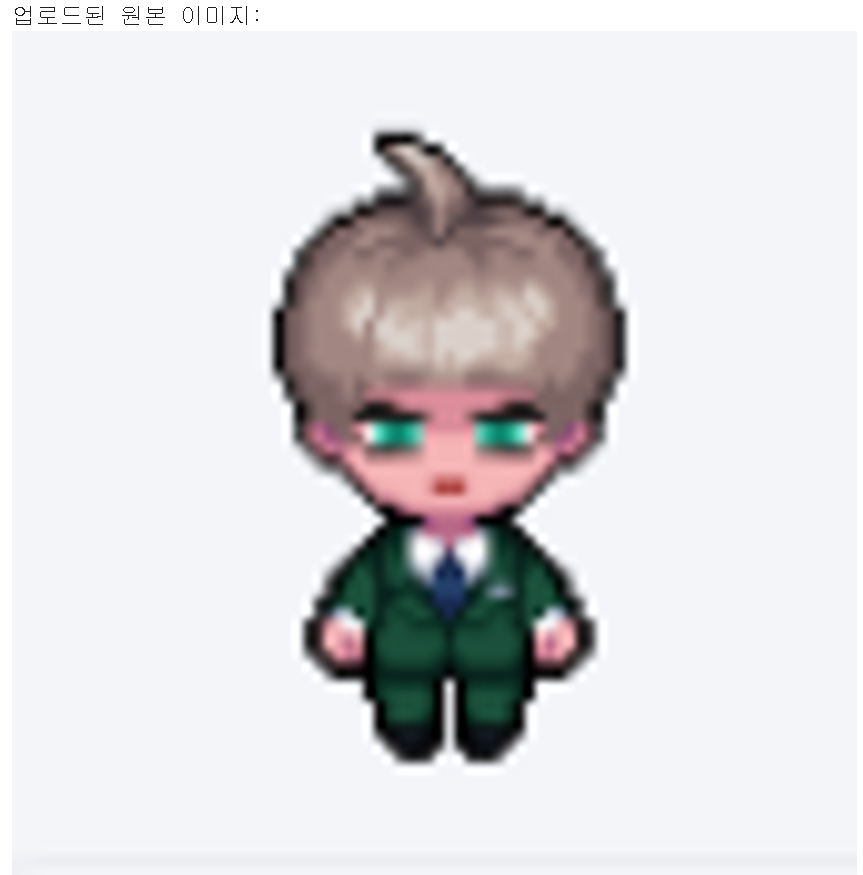

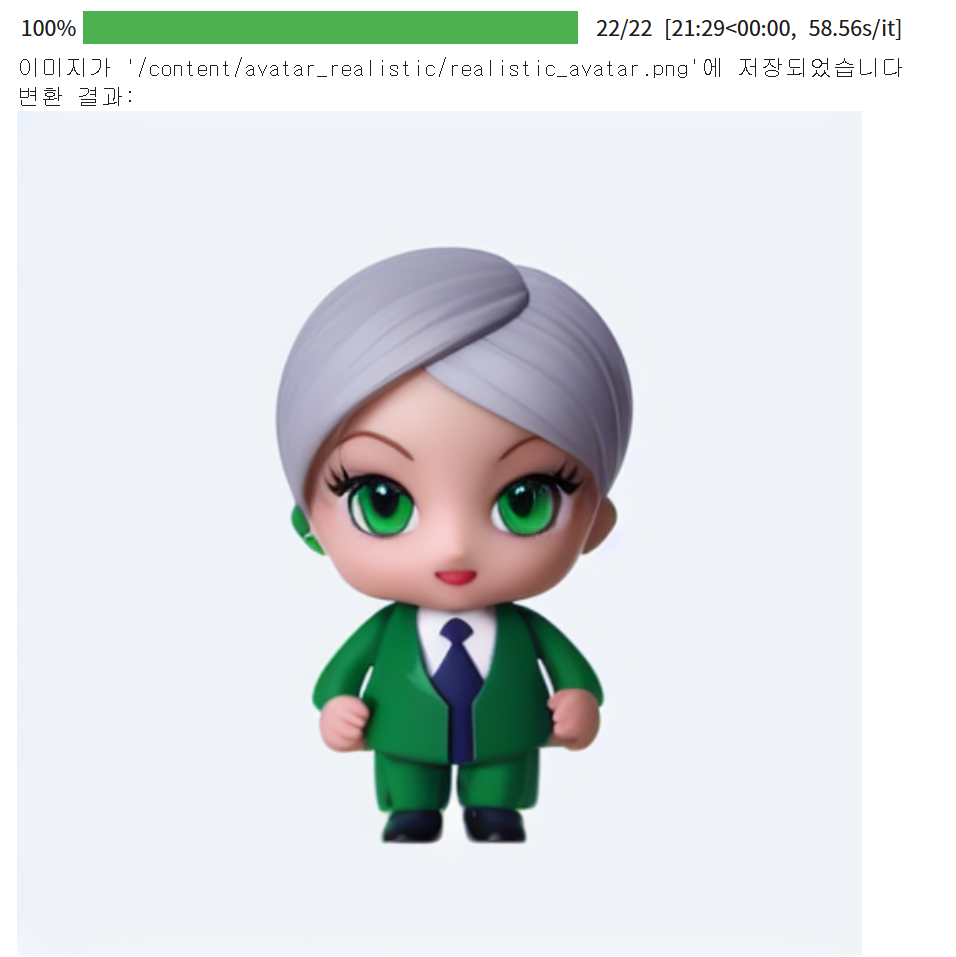

회고: 다양한 방법으로 이미지를 생성해보고, 또 파라미터를 수정하면서 퀄리티가 어떻게 달라지는 지 실험하는 과정이 흥미로웠습니다! 다만, 눈이나 팔 같은 부분을 잘 만드는 걸 어려워하는 것 같아요. 또 비슷한 색깔로 연상되는 물체가 있으면 하나의 덩어리로 만들어버리더라구요. 원숭이 다리랑 나뭇가지... 다음에는 조금 더 퀄리티를 높여보고 싶습니다! 한달 동안 사용 가능한 gpu가 다운되어서 프로젝트부터는 cpu로 하다보니 오랜 시간이 걸렸습니다 ㅠㅠ 하루가 지나도 복구가 안되더라구요... 한 이미지 당 40분이라니.. gpu의 소중함을 깨달았습니다 !  